# Naive neural network

In [1]:
# Handling paths for importing code
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

from Code.utilities import MSELoss_method, cross_entropy_loss_method, predict, accuracy_func
from Code.descent_methods import SGD_adam, SGD
from Code.data_handling import load_MNIST_8, load_MNIST_28, append_run_to_file, load_run_from_file
from Code.softmax_regression import softmax_beta_init, softmax_model, softmax
from Code.neural_network import _beta_init, get_neural_network_model
from Code.plot import *

from jax import jit, nn, grad
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

# Set the default font size for text elements (e.g., titles, labels)
import matplotlib as mpl
mpl.rcParams['font.size'] = 16
mpl.rcParams["axes.labelsize"] = 14
mpl.rcParams["axes.titlesize"] = 16
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['font.family'] = 'sans-serif'
plt.rcParams['xtick.labelsize']=12
plt.rcParams['ytick.labelsize']=12

# Set filename start. Create the folder if gone
filepath_location = "Figures/b/"
if not os.path.exists(filepath_location):
    os.makedirs(filepath_location[0:-1])

c:\Users\Trond\OneDrive\7. semester\FYS-STK3155 - Anvendt dataanalyse og maskinlæring\Projects\Project3_FYS_STK4155\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Training the neural network

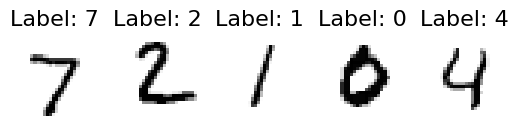

In [2]:
# download MNIST dataset
X_train, y_train, X_test, y_test = load_MNIST_28(flatten_images=True)
# X_train, y_train, X_test, y_test = load_MNIST_8(flatten_images=True)

# Display some images
plot_some_imgs(X_test, y_test)

In [8]:
def single_run(X_train, X_test, y_train, y_test, 
               lr, lam, hidden_layer_num, node_per_hidden, 
               hidden_activation, output_activation=softmax,
               epochs=300, batch_size=32, plot_or_not=False,
               loss_func_and_name=(cross_entropy_loss_method, "CE"), #(MSELoss_method, "MSE")
               test_func_and_name=(cross_entropy_loss_method, "CE"), 
               result_filepath=None, store_params=False, intermediate_epochs=None):    
    """
    Performs a training with the given parameters

    Returns result, including the final accuracy scores
    """

    # Initialise beta and create the model
    layer_list = [X_train.shape[1]] + [node_per_hidden]*hidden_layer_num + [y_train.shape[1]]
    beta0 = _beta_init(layer_list)
    model = jit(get_neural_network_model(hidden_layer_num,activation=hidden_activation,
                                         output_activation=output_activation))

    # Create gradient from loss function
    loss_func = jit(loss_func_and_name[0](model=model, lam=lam))   
    loss_grad = jit(grad(loss_func))

    # (usually MSE) loss function for evaluation
    if plot_or_not:
        test_func = jit(test_func_and_name[0])
        test_func = loss_func
    else:
        test_func = None

    # Perform training. We use adam, add the test index
    result = SGD_adam(X_train, y_train, X_test, y_test, 
                      grad_method=loss_grad,beta0=beta0, 
                      n_epochs=epochs, batch_size=batch_size,
                      test_loss_func= test_func, lr=lr, 
                      intermediate_epochs=intermediate_epochs)

    # Plot if wanted ...
    if plot_or_not:
        n_batches = int(y_train.shape[0] / batch_size)
        plot_test_results(result["test_loss_list"], result["train_loss_list"], n_batches, ylabel="CE")

    # Add accuracy scores
    result["test_accuracy"]  = accuracy_func(model, result["beta_final"], X_test, y_test)
    result["train_accuracy"] = accuracy_func(model, result["beta_final"], X_train, y_train)
    # Also store the model for potential later use
    result["model"] = model

    # Store the result to given file
    if result_filepath:

        _dict_to_store =  { "lr"                : lr, 
                            "lam"               : lam,
                            "batch_size"        : batch_size,
                            "hidden_layer_num"  : hidden_layer_num, 
                            "node_per_hidden"   : node_per_hidden, 
                            "hidden_activation" : hidden_activation.__name__,
                            "output_activation" : output_activation.__name__,
                            "loss_function"     : loss_func_and_name[1],
                            "train_num"         : y_train.shape[0],
                            "test_num"          : y_test.shape[0]
                          }
        if store_params:
            _dict_to_store["beta_final"] = {key: value.tolist() for key, value in result["beta_final"].items()}

        # Possibility of storing run with fewer epochs
        if intermediate_epochs is not None:
            for ie, be in zip(intermediate_epochs, result["beta_intermediate"]):
                _dict_to_store = {"test_accuracy"     : accuracy_func(model, be, X_test, y_test), 
                                  "train_accuracy"    : accuracy_func(model, be, X_train, y_train),
                                  "epochs"            : ie} | _dict_to_store

                append_run_to_file(result_filepath, _dict_to_store)

        _dict_to_store = {"test_accuracy"     : result["test_accuracy"], 
                          "train_accuracy"    : result["train_accuracy"],
                          "epochs"            : epochs} | _dict_to_store
        append_run_to_file(result_filepath, _dict_to_store)

    return result

# ## A demonstration
# epochs = 50
# batch_size = 8192 #4096 2048 # 128 # 1024
# lr = 0.01 # 0.01
# result = single_run(X_train, X_test, y_train, y_test, 
#                     lr=lr, lam=0.0001, hidden_layer_num=3, node_per_hidden=100, hidden_activation=nn.sigmoid,
#                     epochs=epochs, batch_size=batch_size, 
#                     plot_or_not=True, result_filepath="test.json")

# print("test: ", result["test_accuracy"])
# print("train: ", result["train_accuracy"])

# print("CE test: ", result["test_loss_list"][-1])
# print("CE train: ", result["train_loss_list"][-1])


### Architecture

In [23]:
epochs     = 10
lr         = 0.01
batch_size = 128
lam = 0
filepath = "Results/neural_28.json"

hidden_layer_nums = [1, 2, 3]#, 4, 5, 6, 7, 8, 0]
hidden_node_nums = [8, 16, 32, 64, 128, 256, 512] # 784 = size of input layer 
hidden_node_nums.reverse()

for layers in hidden_layer_nums:
    for nodes in hidden_node_nums:

        result = single_run(X_train, X_test, y_train, y_test, 
                        lr=lr, lam=lam, hidden_layer_num=layers, node_per_hidden=nodes, hidden_activation=nn.sigmoid,
                        epochs=epochs, batch_size=batch_size, 
                        plot_or_not=False, result_filepath=filepath)
        print(f"layers: {layers}, nodes: {nodes}, training_acc: {result['train_accuracy']}, test_acc: {result['test_accuracy']}")

100%|██████████| 10/10 [00:20<00:00,  2.08s/it]


layers: 1, nodes: 512, training_acc: 0.9981499910354614, test_acc: 0.9807000160217285


100%|██████████| 10/10 [00:14<00:00,  1.40s/it]


layers: 1, nodes: 256, training_acc: 0.9988166689872742, test_acc: 0.98089998960495


100%|██████████| 10/10 [00:09<00:00,  1.07it/s]


layers: 1, nodes: 128, training_acc: 0.9975666403770447, test_acc: 0.9786999821662903


100%|██████████| 10/10 [00:07<00:00,  1.28it/s]


layers: 1, nodes: 64, training_acc: 0.9921000003814697, test_acc: 0.9711999893188477


100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


layers: 1, nodes: 32, training_acc: 0.9788333177566528, test_acc: 0.9591000080108643


100%|██████████| 10/10 [00:05<00:00,  1.69it/s]


layers: 1, nodes: 16, training_acc: 0.9568833112716675, test_acc: 0.9455000162124634


100%|██████████| 10/10 [00:05<00:00,  1.81it/s]


layers: 1, nodes: 8, training_acc: 0.9262499809265137, test_acc: 0.9118000268936157


100%|██████████| 10/10 [00:35<00:00,  3.54s/it]


layers: 2, nodes: 512, training_acc: 0.9964666962623596, test_acc: 0.98089998960495


100%|██████████| 10/10 [00:18<00:00,  1.90s/it]


layers: 2, nodes: 256, training_acc: 0.9966166615486145, test_acc: 0.9775999784469604


100%|██████████| 10/10 [00:12<00:00,  1.23s/it]


layers: 2, nodes: 128, training_acc: 0.9958666563034058, test_acc: 0.9771999716758728


100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


layers: 2, nodes: 64, training_acc: 0.9911166429519653, test_acc: 0.9695000052452087


100%|██████████| 10/10 [00:07<00:00,  1.29it/s]


layers: 2, nodes: 32, training_acc: 0.9831166863441467, test_acc: 0.9631999731063843


100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


{'Node': [100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100], 'Layer': [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], 'Accuracy': [0.957099974155426, 0.9617999792098999, 0.9613999724388123, 0.9714000225067139, 0.9635999798774719, 0.9646000266075134, 0.9703999757766724, 0.9664000272750854, 0.9710000157356262, 0.9623000025749207, 0.965499997138977, 0.967199981212616, 0.9627000093460083, 0.9692000150680542, 0.9602000117301941, 0.9587000012397766, 0.9599999785423279, 0.9629999995231628, 0.9617000222206116, 0.9681000113487244, 0.9642000198364258, 0.972100019454956, 0.9674999713897705, 0.964

c:\Users\Trond\OneDrive\7. semester\FYS-STK3155 - Anvendt dataanalyse og maskinlæring\Projects\Project3_FYS_STK4155\Code\plot.py:133: RuntimeWarning: invalid value encountered in divide
  zs[:, 1:] = (ys[:, 1:] - ymins[1:]) / dys[1:] * dys[0] + ymins[0]
c:\Users\Trond\OneDrive\7. semester\FYS-STK3155 - Anvendt dataanalyse og maskinlæring\Projects\Project3_FYS_STK4155\Code\plot.py:142: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(ymins[i], ymaxs[i])
c:\Users\Trond\OneDrive\7. semester\FYS-STK3155 - Anvendt dataanalyse og maskinlæring\Projects\Project3_FYS_STK4155\Code\plot.py:177: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


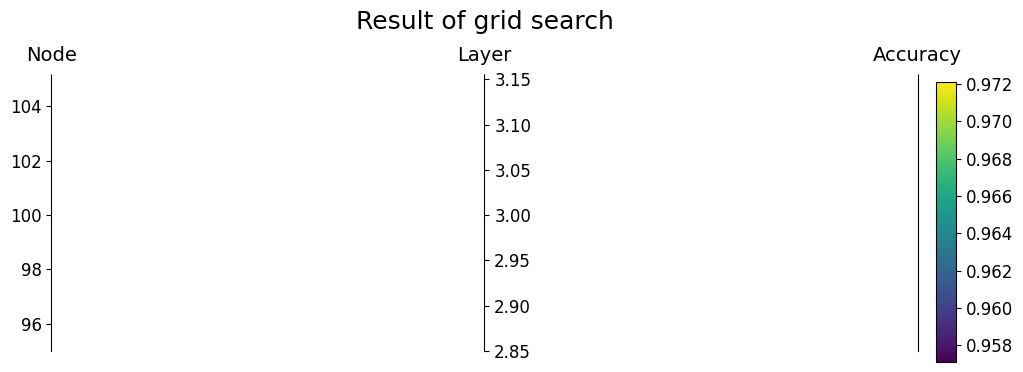

In [21]:
run_list = load_run_from_file("Results/neural_28.json")


data = {
    # "Epochs": [],
    # "Batch size": [],
    # "Learning rate": [],
    # "Regularisation": [],
    "Node": [],
    "Layer": [],
    "Accuracy": [],
}

for run in run_list:

    if run["test_accuracy"] >= 0:
    
        data["Node"].append(run["node_per_hidden"])
        data["Layer"].append(run["hidden_layer_num"])
        data["Accuracy"].append(run["test_accuracy"])

plot_grid_search_result(data)

nodes per layer: 1


100%|██████████| 300/300 [00:03<00:00, 88.24it/s] 


nodes per layer: 11


 17%|█▋        | 51/300 [00:00<00:03, 71.33it/s]


KeyboardInterrupt: 

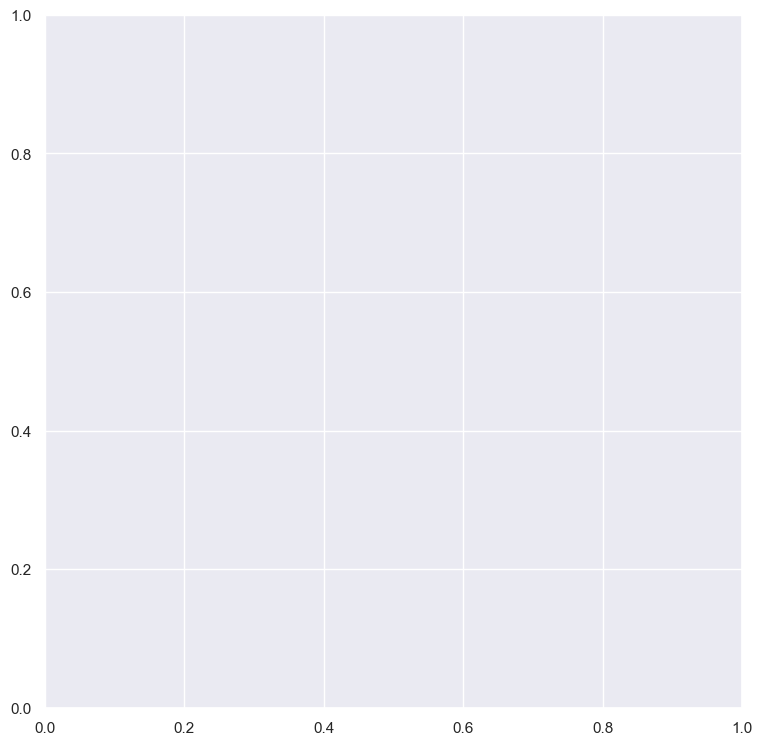

In [ ]:
def hidden_node_hidden_layer_grid(savefig=False, nreps=5):
    lam = 1e-5
    lr = 0.01
    hidden_activation = nn.tanh
    hidden_activation_name = "tanh"
    
    # Maximal number of hidden layers and nodes
    n = 6
    # m = 19
    m = 60
    
    filename = filepath_location + f"lr={lr}_lambda={lam}_hidden_activation_func={hidden_activation_name}_nreps={nreps}__hidden_layer_num_grid_experiment_classification.png"

    fig, ax = plt.subplots(figsize=(9, 9))

    hidden_layer_numbers = np.arange(1, n + 1)
    nodes_per_layer_list = np.arange(1, m, m//n)

    # Arrays for storing the errors. temporary result to call result.get
    test_errs_all = np.zeros(shape=(n, n))
    train_errs_all = np.zeros(shape=(n, n))
    result = {}

    # Loop over nodes per layer
    for i, nodes_per_layer in enumerate(nodes_per_layer_list):
        print(f"nodes per layer: {nodes_per_layer}")
        
        # Loop over number of hidden layers
        for j, hidden_layer_number in enumerate(hidden_layer_numbers):
        
            # Accumulation variables for averaging over nreps
            s_test = 0.0
            s_train = 0.0
        
            # Run nreps times 
            for k in range(nreps):
                result = single_run(X, y, lr=lr, lam=lam, hidden_layer_num=hidden_layer_number, 
                                    node_per_hidden=nodes_per_layer, hidden_activation=hidden_activation, 
                                    test_index=result.get("test_index"))
                s_test += result["test_accuracy"]
                s_train += result["train_accuracy"]

            test_errs_all[i, j] = s_test/nreps
            train_errs_all[i, j] = s_train/nreps


    sns.heatmap(test_errs_all, annot=True, ax=ax, cmap="viridis", cbar=True)

    # Title
    ax.set_title("Final test accuracy")

    # Handle labels
    ax.set_xlabel("Number of hidden layers")
    ax.set_ylabel("Number of nodes per layer")

    ax.set_yticklabels(nodes_per_layer_list)
    ax.set_xticklabels(hidden_layer_numbers)
    

    plt.tight_layout()
    if savefig:
        fig.savefig(filename)
    plt.show()

    return {"hidden_layer_sizes":hidden_layer_numbers, "test_error":test_errs_all, "train_error":train_errs_all}

_ = hidden_node_hidden_layer_grid(savefig=True, nreps=1)

### Final model evaluation

We make confusion matrix ...

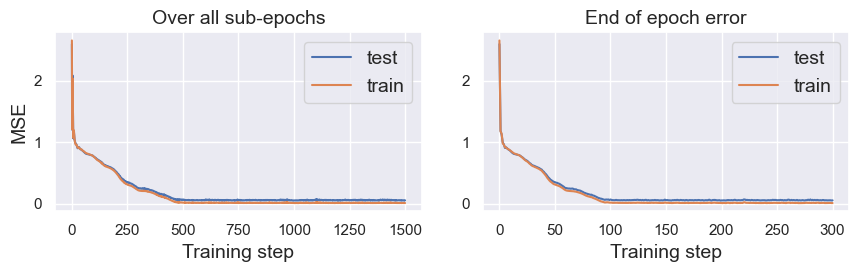

test:  0.97771585
train:  1.0
MSE test:  0.052502476
MSE train:  0.008526792


In [ ]:
epochs = 300
result = single_run(X, y, lr=0.01, lam=0.0001, hidden_layer_num=5, node_per_hidden=40, 
           hidden_activation=nn.sigmoid, epochs=epochs, test_index=test_index, plot_or_not=True)

print("test: ", result["test_accuracy"])
print("train: ", result["train_accuracy"])

print("MSE test: ", result["test_loss_list"][0][-1])
print("MSE train: ", result["train_loss_list"][0][-1])


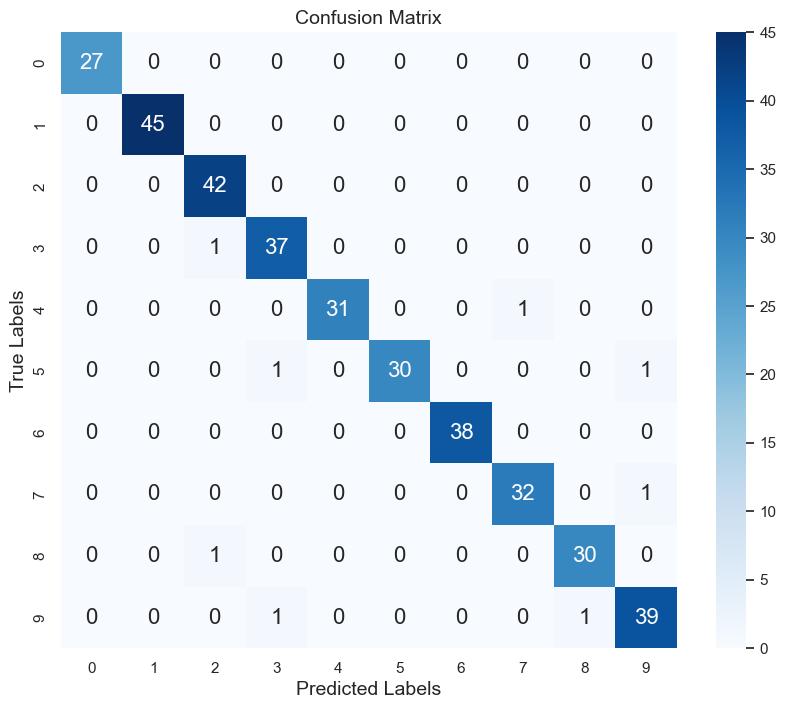

In [ ]:
from sklearn.metrics import confusion_matrix

# Example true labels and predicted labels
nums_pred = predict(result["model"], result["beta_final"], X_test)
nums_gt   = jnp.array([jnp.argmax(y_sample) for y_sample in y_test])

# Create confusion matrix
conf_matrix = confusion_matrix(nums_gt, nums_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", square=True,
            xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

Also want to see exactly where the model fails ...

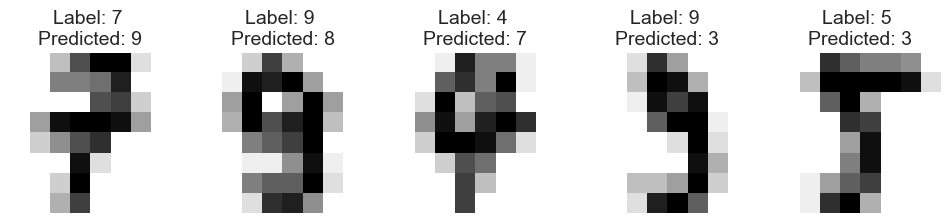

In [ ]:
# Format the faulty predictions back
indeces = nums_gt != nums_pred
imgs = [img.reshape(8, 8) for img in X_test[indeces]]
labels_pred = nums_pred[indeces]
labels_gt   = nums_gt[indeces]

# Plot the 5 first
for i, img in enumerate(imgs[0:5]):

    plt.subplot(1, 5, i+1)
    plt.axis('off')
    plt.imshow(img, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title(f"Label: {labels_gt[i]} \nPredicted: {labels_pred[i]}")

plt.show()